# 50.039 Theory and Practice of Deep Learning Project 2024

Group 10
- Issac Jose Ignatius (1004999)
- Mahima Sharma (1006106)
- Dian Maisara (1006377)


### Import all relevant libraries

In [132]:
# Numpy
import numpy as np
# Pandas
import pandas as pd

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Torchvision
import torchvision
import torchvision.transforms as T
from torchvision.transforms import v2
from torchvision.io import read_image, ImageReadMode

from torchmetrics.classification import MulticlassF1Score, MulticlassPrecision, MulticlassRecall, MulticlassConfusionMatrix

import math
from tqdm.notebook import tqdm

# File Operations
import os

import sys
sys.path.insert(0, '../utils')
from models import ConvSingle
from helpers import load_model, detach_tensor

In [133]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu") 
print(device)

cuda


In [134]:
DATA_PATH = os.path.join(os.path.abspath(''), "../../original")
print(DATA_PATH)

c:\Users\dianm\Downloads\Dataset\2024_TPDL\notebooks\../../original


### Load in Labels 

In [135]:
# Bug in Path present in training dataset
def fix_error_paths(row):
    row = row.replace("//", "/")
    return row

def str_to_array(row):
    ndarray = np.fromstring(
                row.replace('\n','')
                    .replace('[','')
                    .replace(']','')
                    .replace('  ',' '), 
                    sep=' ')
    return ndarray

In [136]:
labels = ['Pleural Effusion', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Edema', 'Pleural Other', 'Fracture', 'Support Devices']

test_df = pd.read_csv("../data/processed/test_one_hot_encoded.csv", index_col=False)
test_df["Path"] = test_df["Path"].apply(fix_error_paths)

for label in labels:
    test_df[label] = test_df[label].apply(str_to_array)

display(test_df)

,Path,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,test/patient64741/study1/view1_frontal.jpg,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]"
1,test/patient64742/study1/view1_frontal.jpg,"[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]"
2,test/patient64743/study1/view1_frontal.jpg,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]"
3,test/patient64744/study1/view1_frontal.jpg,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]"
4,test/patient64744/study1/view2_lateral.jpg,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663,test/patient65236/study1/view1_frontal.jpg,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]"
664,test/patient65237/study1/view1_frontal.jpg,"[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]"
665,test/patient65238/study1/view1_frontal.jpg,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]"
666,test/patient65239/study1/view1_frontal.jpg,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]"


In [137]:
def preprocess_pEffClassification(df):
    df.drop(columns=['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Edema', 'Pleural Other', 'Fracture', 'Support Devices'], axis=1, inplace=True)
    return df

def preprocess_cardioClassification(df):
    df.drop(columns=['Enlarged Cardiomediastinum', 'Pleural Effusion', 'Lung Opacity', 'Lung Lesion', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Edema', 'Pleural Other', 'Fracture', 'Support Devices'], axis=1, inplace=True)
    return df

def ohe_to_class(row):
    if np.sum(row) > 0:
        return np.argmax(row)
    else:
        return -100

# Creates copy of train_df for pEff and cardio
test_p = test_df.copy()
test_c = test_df.copy()

In [138]:
# Drop all other labels
pEff_test = preprocess_pEffClassification(test_p)
# Replace OHE with int class labels
pEff_test["Pleural Effusion"] = pEff_test["Pleural Effusion"].apply(ohe_to_class)
display(pEff_test)

,Path,Pleural Effusion
0,test/patient64741/study1/view1_frontal.jpg,1
1,test/patient64742/study1/view1_frontal.jpg,1
2,test/patient64743/study1/view1_frontal.jpg,1
3,test/patient64744/study1/view1_frontal.jpg,1
4,test/patient64744/study1/view2_lateral.jpg,1
...,...,...
663,test/patient65236/study1/view1_frontal.jpg,1
664,test/patient65237/study1/view1_frontal.jpg,1
665,test/patient65238/study1/view1_frontal.jpg,1
666,test/patient65239/study1/view1_frontal.jpg,1


In [139]:
# Drop all other labels
cardio_test = preprocess_cardioClassification(test_c)
# Replace OHE with int class labels
cardio_test["Cardiomegaly"] = cardio_test["Cardiomegaly"].apply(ohe_to_class)
display(cardio_test)

,Path,Cardiomegaly
0,test/patient64741/study1/view1_frontal.jpg,2
1,test/patient64742/study1/view1_frontal.jpg,1
2,test/patient64743/study1/view1_frontal.jpg,2
3,test/patient64744/study1/view1_frontal.jpg,1
4,test/patient64744/study1/view2_lateral.jpg,1
...,...,...
663,test/patient65236/study1/view1_frontal.jpg,2
664,test/patient65237/study1/view1_frontal.jpg,1
665,test/patient65238/study1/view1_frontal.jpg,1
666,test/patient65239/study1/view1_frontal.jpg,2


### Custom Dataset implementation

In [140]:
# Implementation of Custom Dataset Class for CheXPhoto Dataset
class CheXDataset(Dataset):
    # Accepts dataframe object and str
    def __init__(self, df: pd.DataFrame, px_size: int = 256):
        self.dataframe = df.copy()
        self.px_size = px_size
        self.transform = T.Compose([
            v2.Resize((self.px_size, self.px_size), interpolation=T.InterpolationMode.BICUBIC)
        ])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        x_path = DATA_PATH + "/" + self.dataframe.iloc[idx, 0].split("CheXphoto-v1.0", 1)[-1]
        resized_x_tensor = self.transform(read_image(x_path, mode = ImageReadMode.RGB)) /255
        y = torch.tensor(self.dataframe.iloc[idx, 1]).type(torch.LongTensor)
        return resized_x_tensor, y

### Custom Dataloader

In [141]:
# Load into custom Dataset
pEff_test_data = CheXDataset(pEff_test)
cardio_test_data = CheXDataset(cardio_test)

# Load into DataLoader
batch_size = 128
pEff_test_loader = DataLoader(pEff_test_data, batch_size)
cardio_test_loader = DataLoader(cardio_test_data, batch_size)

### Tester

In [142]:
from tqdm.notebook import tnrange, tqdm

def test(model, test_loader):
    model.eval()

    test_total = 0

    f1 = MulticlassF1Score(num_classes=3, ignore_index=-100).to(device)
    precision = MulticlassPrecision(num_classes=3, ignore_index=-100).to(device)
    recall = MulticlassRecall(num_classes=3, ignore_index=-100).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=3, ignore_index=-100).to(device)

    with torch.no_grad():
        for inputs, outputs in tqdm(test_loader):
            inputs_re, outputs_re = inputs.to(device), outputs.to(device)
            preds = model(inputs_re)

            test_total += outputs_re.size(0)

            f1.update(preds, outputs_re)
            precision.update(preds, outputs_re)
            recall.update(preds, outputs_re)
            confusion_matrix.update(preds, outputs_re)

    test_f1 = f1.compute()
    test_precision = precision.compute()
    test_recall = recall.compute()
    test_confusion_matrix = confusion_matrix.compute()

    print(f'--- Test F1: {test_f1:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, \n')
    print(f'--- Test Confusion Matrix: \n{test_confusion_matrix}\n')
    return test_f1, test_precision, test_recall, test_confusion_matrix

## Evaluation

### Full Dataset Training

#### Pleural Effusion

In [143]:
model_full_pEff = load_model(ConvSingle, "conv-single/full_pEff", 9, path="../models").to(device)
print(model_full_pEff)

ConvSingle(
  (conv_layers): Sequential(
    (0): ConvolutionBlock(
      (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvolutionBlock(
      (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvolutionBlock(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fals

In [144]:
convsingle_full_pEff = test(model_full_pEff, cardio_test_loader)

  0%|          | 0/6 [00:00<?, ?it/s]

--- Test F1: 0.6306, Test Precision: 0.6548, Test Recall: 0.7000, 

--- Test Confusion Matrix: 
tensor([[  0,   0,   0],
        [  0, 293, 200],
        [  0,  34, 141]], device='cuda:0')



#### Cardio

In [145]:
model_full_cardio = load_model(ConvSingle, "conv-single/full_cardio", 9, path="../models").to(device)
print(model_full_cardio)

ConvSingle(
  (conv_layers): Sequential(
    (0): ConvolutionBlock(
      (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvolutionBlock(
      (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvolutionBlock(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fals

In [146]:
convsingle_full_cardio = test(model_full_cardio, cardio_test_loader)

  0%|          | 0/6 [00:00<?, ?it/s]

--- Test F1: 0.6145, Test Precision: 0.6607, Test Recall: 0.7041, 

--- Test Confusion Matrix: 
tensor([[  0,   0,   0],
        [  0, 266, 227],
        [  0,  23, 152]], device='cuda:0')



### Random Sampling

#### Pleural Effusion

In [147]:
model_randomSampler_pEff = load_model(ConvSingle, "conv-single/randomSampler_pEff", 9, path="../models").to(device)
print(model_randomSampler_pEff)

ConvSingle(
  (conv_layers): Sequential(
    (0): ConvolutionBlock(
      (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvolutionBlock(
      (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvolutionBlock(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fals

In [148]:
convsingle_sampling_pEff = test(model_randomSampler_pEff, cardio_test_loader)

  0%|          | 0/6 [00:00<?, ?it/s]

--- Test F1: 0.4254, Test Precision: 0.6191, Test Recall: 0.5960, 

--- Test Confusion Matrix: 
tensor([[  0,   0,   0],
        [  0, 120, 373],
        [  0,   9, 166]], device='cuda:0')



#### Cardiomegaly

In [149]:
model_randomSampler_cardio = load_model(ConvSingle, "conv-single/randomSampler_cardio", 9, path="../models").to(device)
print(model_randomSampler_cardio)

ConvSingle(
  (conv_layers): Sequential(
    (0): ConvolutionBlock(
      (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvolutionBlock(
      (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvolutionBlock(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fals

In [150]:
convsingle_sampling_cardio = test(model_randomSampler_cardio, cardio_test_loader)

  0%|          | 0/6 [00:00<?, ?it/s]

--- Test F1: 0.3341, Test Precision: 0.6201, Test Recall: 0.5553, 

--- Test Confusion Matrix: 
tensor([[  0,   0,   0],
        [  0,  63, 430],
        [  0,   3, 172]], device='cuda:0')



In [151]:
results = [convsingle_full_pEff, convsingle_full_cardio, convsingle_sampling_pEff, convsingle_sampling_cardio]

results_df = pd.DataFrame(results)
display(results_df)

,0,1,2,3
0,"tensor(0.6306, device='cuda:0')","tensor(0.6548, device='cuda:0')","tensor(0.7000, device='cuda:0')","[[tensor(0, device='cuda:0'), tensor(0, device..."
1,"tensor(0.6145, device='cuda:0')","tensor(0.6607, device='cuda:0')","tensor(0.7041, device='cuda:0')","[[tensor(0, device='cuda:0'), tensor(0, device..."
2,"tensor(0.4254, device='cuda:0')","tensor(0.6191, device='cuda:0')","tensor(0.5960, device='cuda:0')","[[tensor(0, device='cuda:0'), tensor(0, device..."
3,"tensor(0.3341, device='cuda:0')","tensor(0.6201, device='cuda:0')","tensor(0.5553, device='cuda:0')","[[tensor(0, device='cuda:0'), tensor(0, device..."


In [152]:
results = [convsingle_full_pEff, convsingle_full_cardio, convsingle_sampling_pEff, convsingle_sampling_cardio]

results_df = pd.DataFrame(results, columns=["F1", "Precision", "Recall", "Confusion_Matrix"], index=["ConvSingle_Full_pEff", "ConvSingle_Full_cardio", "ConvSingle_Sampling_pEff", "ConvSingle_Sampling_cardio"])
display(results_df)

,F1,Precision,Recall,Confusion_Matrix
ConvSingle_Full_pEff,"tensor(0.6306, device='cuda:0')","tensor(0.6548, device='cuda:0')","tensor(0.7000, device='cuda:0')","[[tensor(0, device='cuda:0'), tensor(0, device..."
ConvSingle_Full_cardio,"tensor(0.6145, device='cuda:0')","tensor(0.6607, device='cuda:0')","tensor(0.7041, device='cuda:0')","[[tensor(0, device='cuda:0'), tensor(0, device..."
ConvSingle_Sampling_pEff,"tensor(0.4254, device='cuda:0')","tensor(0.6191, device='cuda:0')","tensor(0.5960, device='cuda:0')","[[tensor(0, device='cuda:0'), tensor(0, device..."
ConvSingle_Sampling_cardio,"tensor(0.3341, device='cuda:0')","tensor(0.6201, device='cuda:0')","tensor(0.5553, device='cuda:0')","[[tensor(0, device='cuda:0'), tensor(0, device..."


In [153]:
results_df.drop(columns=["Confusion_Matrix"], inplace=True)
display(results_df)

,F1,Precision,Recall
ConvSingle_Full_pEff,"tensor(0.6306, device='cuda:0')","tensor(0.6548, device='cuda:0')","tensor(0.7000, device='cuda:0')"
ConvSingle_Full_cardio,"tensor(0.6145, device='cuda:0')","tensor(0.6607, device='cuda:0')","tensor(0.7041, device='cuda:0')"
ConvSingle_Sampling_pEff,"tensor(0.4254, device='cuda:0')","tensor(0.6191, device='cuda:0')","tensor(0.5960, device='cuda:0')"
ConvSingle_Sampling_cardio,"tensor(0.3341, device='cuda:0')","tensor(0.6201, device='cuda:0')","tensor(0.5553, device='cuda:0')"


In [154]:
for col in results_df.columns.to_list():
    results_df[col] = results_df[col].apply(detach_tensor)

display(results_df)

,F1,Precision,Recall
ConvSingle_Full_pEff,0.630573,0.654757,0.700017
ConvSingle_Full_cardio,0.614522,0.660735,0.704063
ConvSingle_Sampling_pEff,0.425419,0.619105,0.595990
ConvSingle_Sampling_cardio,0.334065,0.620130,0.555323


#### Visualisation

In [155]:
import matplotlib.pyplot as plt

In [166]:
results_df["F1"][0:2].to_list()

[0.6305729150772095, 0.6145216822624207]

In [165]:
results_df["F1"][0:2].to_list()

[0.42541903257369995, 0.3340654671192169]

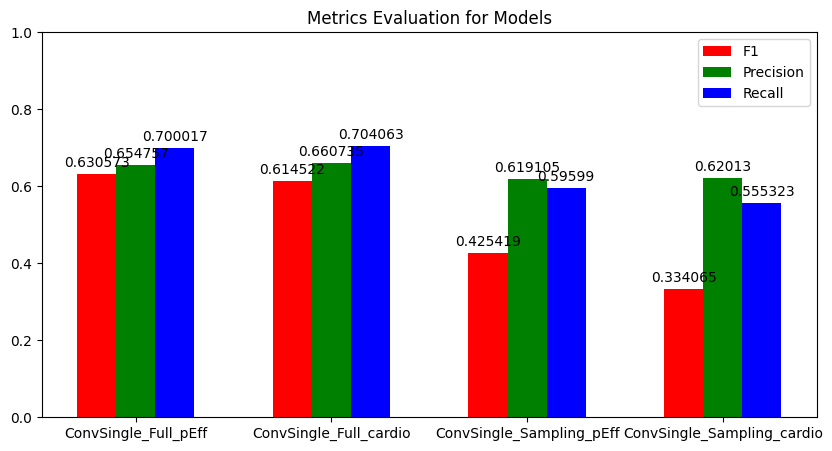

In [178]:
ind = np.arange(len(results_df))
width = 0.2
plt.figure(figsize=(10, 5))
bar1 = plt.bar(ind - width, results_df["F1"], width, label="F1", color='r')
bar2 = plt.bar(ind, results_df["Precision"], width, label="Precision", color='g')
bar3 = plt.bar(ind + width, results_df["Recall"], width, label="Recall", color='b')
plt.bar_label(bar1, padding=3)
plt.bar_label(bar2, padding=3)
plt.bar_label(bar3, padding=3)
plt.title("Metrics Evaluation for Models")
plt.xticks(ind, results_df.index.to_list())
plt.ylim((0,1))
plt.legend()